In [1]:
# Colab cell
try:
    import google.colab
    IN_COLAB = True
    !wget -q https://raw.githubusercontent.com/Competencia-de-Climate-Change/WeatherBench/master/src/ml_training.py
    !pip install -q -U zarr
    !pip install -q -U fsspec
    !pip install -q -U gcsfs
    !pip install -q -U xarray
except:
    IN_COLAB = False

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xarray as xr
import fsspec


import matplotlib.pyplot as plt
from matplotlib import colors as c

import numpy as np
import pandas as pd


from skimage import color
from skimage.feature import hog

import hvplot.xarray
import geoviews
from cartopy import crs

In [3]:
ds = xr.open_zarr(fsspec.get_mapper('gcs://weather-bench/region_zarr/'), consolidated=True)

ds = ds.isel(lon=slice(0,12))

print("Tamaño en GB:", ds.nbytes / 1e9)

nlat, nlon = len(ds.lat), len(ds.lon)
print(nlat,'x',nlon)

ds

Tamaño en GB: 16.564237876
12 x 12


<xarray.Dataset>
Dimensions:    (lat: 12, level: 13, lon: 12, time: 350640)
Coordinates:
  * lat        (lat) float64 -70.31 -64.69 -59.06 ... -19.69 -14.06 -8.438
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon        (lon) float64 247.5 253.1 258.8 264.4 ... 292.5 298.1 303.8 309.4
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    lat2d      (lat, lon) float64 dask.array<chunksize=(12, 12), meta=np.ndarray>
    lon2d      (lat, lon) float64 dask.array<chunksize=(12, 12), meta=np.ndarray>
    lsm        (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    orography  (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    pv         (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    q          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    r          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    slt        (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    tcc        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    u10        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    v10        (time, lat, lon) float32 dask.array<chunksize=(43830, 2, 4), meta=np.ndarray>
    vo         (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
    z          (time, level, lat, lon) float32 dask.array<chunksize=(43830, 2, 3, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-03-08 20:51:24 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### One month mean

In [4]:
t2m_daily_mean = ds['t2m'].resample({'time': '1D'}).mean()
t2m_monthly_mean = ds['t2m'].resample({'time': '1M'}).mean()


print(len(ds.time) // (24), len(ds['t2m'].resample(time='1D').mean()))

t2m_daily_mean

14610 14610


<xarray.DataArray 't2m' (time: 14610, lat: 12, lon: 12)>
dask.array<stack, shape=(14610, 12, 12), dtype=float32, chunksize=(1, 2, 4), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
  * lat      (lat) float64 -70.31 -64.69 -59.06 -53.44 ... -19.69 -14.06 -8.438
  * lon      (lon) float64 247.5 253.1 258.8 264.4 ... 292.5 298.1 303.8 309.4

In [5]:
t2m_daily_mean.isel(time=12).hvplot.image(cmap='viridis')

:Image   [lon,lat]   (t2m)

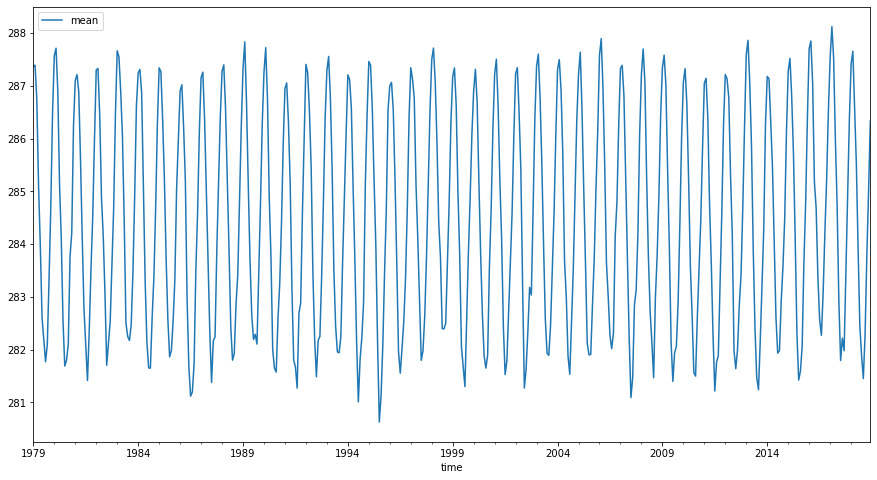

In [6]:
df = pd.DataFrame(columns=['time', 'min', 'max', 'mean'])

ds_to_df = t2m_monthly_mean

df['time'] = ds_to_df.time
df['mean'] = ds_to_df.mean(['lat', 'lon']).values
df['min'] = ds_to_df.min(['lat', 'lon']).values
df['max'] = ds_to_df.max(['lat', 'lon']).values

f, ax = plt.subplots(figsize=(15,8))

df.plot(x='time', y='mean', ax=ax)
plt.show()

# Clustering Ideas

1. Perform clustering over monthly mean  
    -> study if results are ok
    
    
2. Perform clustering for timeseries  
    -> study changes over time

spatiotemporal db-scan : https://github.com/eren-ck/st_dbscan

change detection : https://appliedmachinelearning.blog/2017/11/25/unsupervised-changed-detection-in-multi-temporal-satellite-images-using-pca-k-means-python-code/

tslearn kmeans: https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

In [7]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

In [8]:
X = t2m_monthly_mean.values.reshape(-1, nlat*nlon)

n_obs, m_feats = X.shape

print('Existen', n_obs, 'observaciones con caracteristicas', m_feats)

Existen 480 observaciones con caracteristicas 144


In [9]:
lat_lon_southpole = np.array(-90), ds.lon[len(ds.lon)//2].values
dist_southpole = np.sqrt((ds.lat2d - lat_lon_southpole[0]) ** 2 + (ds.lon2d - lat_lon_southpole[1]) ** 2)

t2m_daily_weighted = np.sqrt(t2m_daily_mean * dist_southpole)

t2m_daily_weighted[0].hvplot.quadmesh(cmap='viridis')

:QuadMesh   [lon,lat]   (value)

In [10]:
# X_weighted = t2m_daily_weighted.values.reshape(-1, nlat*nlon)

## One Monthly Mean Clustering

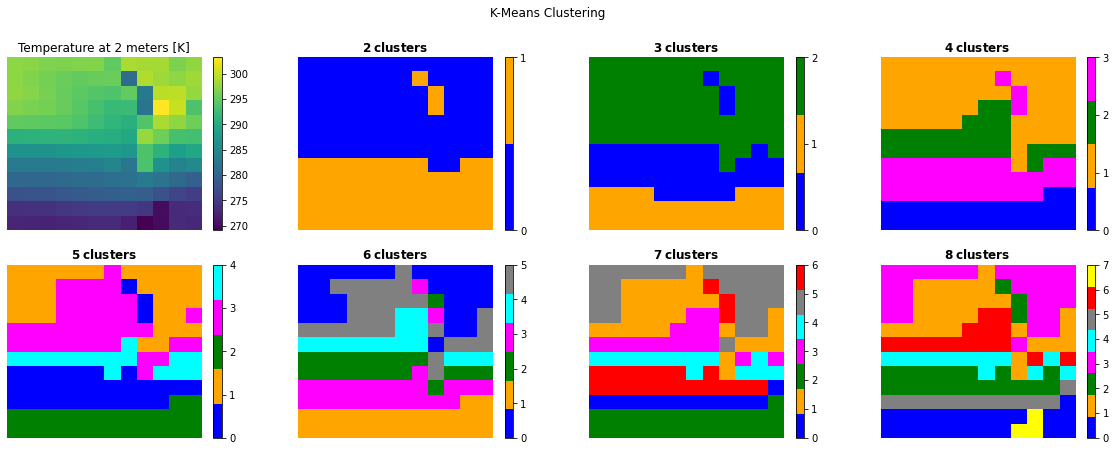

In [11]:
def kmeans_plots(X, max_clusters=9):
    
    fig = plt.figure(figsize=[20,7])
    fig.suptitle('K-Means Clustering')

    # In first subplot add original image
    ax = plt.subplot(241)
    ax.axis('off')
    ax.set_title('Temperature at 2 meters [K]')
    original = ax.imshow(X.reshape(nlon, nlat), cmap='viridis', 
                         interpolation='nearest', aspect='auto', origin='lower')
    plt.colorbar(original, cmap='rainbow', ax=ax, orientation='vertical')
    
    list_colors=['blue','orange', 'green', 'magenta', 'cyan', 'gray', 'red', 'yellow']
    for i in range(2, max_clusters):
        kmeans_cluster  = KMeans(n_clusters=i).fit(X)
        cluster_centers = kmeans_cluster.cluster_centers_
        cluster_labels  = kmeans_cluster.labels_

        X_clustered = kmeans_cluster.labels_
        X_clustered = X_clustered.reshape(12,12)
        
        #Plot the subplot with (i+2)th k-means
        ax = plt.subplot(2,4,i)
        ax.axis('off')
        title = r"$\bf{} \> clusters$".format(str(i))
        ax.set_title(title)
        bounds=range(0,i)
        cmap = c.ListedColormap(list_colors[0:i])
        kmp=ax.imshow(X_clustered, interpolation='nearest', aspect='auto', cmap=cmap,  origin='lower')
        plt.colorbar(kmp, cmap=cmap,  ticks=bounds, ax=ax, orientation='vertical')
    plt.show()
    
kmeans_plots(X[0].reshape(-1,1))

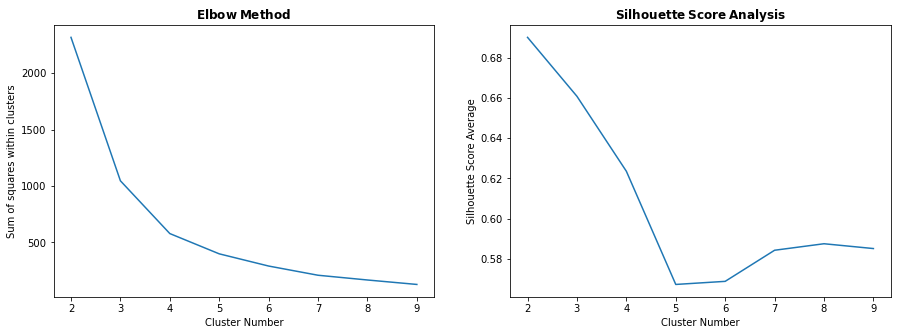

In [12]:
def clustering_analyisis(X, max_clusters=10):
    WCSS = []
    scores = []
    
    c_labels = []
    for k in range(2, max_clusters):
        clusterer = KMeans(k)
        
        cluster_labels = clusterer.fit_predict(X)
        c_labels.append(cluster_labels)
        
        WCSS_iteracion = clusterer.inertia_
        WCSS.append(WCSS_iteracion)

        silhouette_avg = silhouette_score(X, cluster_labels)        
        scores.append(silhouette_avg)
        
    numero_clusters = range(2, max_clusters)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(numero_clusters, WCSS)
    ax1.set_title(r"$\bf{Elbow \> Method}$")
    ax1.set_xlabel("Cluster Number")
    ax1.set_ylabel("Sum of squares within clusters")

    ax2.plot(numero_clusters, scores)
    ax2.set_title(r"$\bf{Silhouette \> Score \> Analysis}$")
    ax2.set_xlabel("Cluster Number")
    ax2.set_ylabel("Silhouette Score Average")
    

    plt.show()

clustering_analyisis(X[0].reshape(-1, 1))

## TimeSeries Monthly Mean Clustering

In [13]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler, to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [14]:
# number_ts, time_size, dimensions
to_time_series_dataset(X.T).shape

(144, 480, 1)

In [21]:
euc_params = {
    'n_clusters': 3, 
    'n_init': 5,
    'metric': "euclidean",
    'verbose': False,
    'random_state': 0,
    'n_jobs': -1
}

dtw_params = {
    'n_clusters': 3, 
    'n_init': 5,
    'metric': "dtw",
    'verbose': False,
    'max_iter_barycenter': 10,
    'random_state': 0,
    'n_jobs': -1
}


In [16]:
def ts_kmeans(X, kmeans_params, transpose=True, title='', ax=None):
    km = TimeSeriesKMeans(**kmeans_params)
    
    if transpose:
        ts_ds = to_time_series_dataset(X.T)
    y_pred = km.fit_predict(ts_ds)
    
    if 'verbose' in kmeans_params and kmeans_params['verbose']:
        print(f'Observations: {X.shape[0]}, features: {X.shape[1]} and predictions shape:{y_pred.shape}')

    if ax is None:
        ax = plt.axes()
    
    
    cmap = c.ListedColormap(['blue','orange', 'green'])
    
    kmp = ax.imshow(y_pred.reshape(nlat, nlon), 
                    interpolation='nearest', 
                    aspect='auto', 
                    cmap=cmap,  
                    origin='lower')
    
    plt.colorbar(kmp, 
                 cmap=cmap,  
                 ticks=range(0,kmeans_params['n_clusters']), 
                 ax=ax, 
                 orientation='vertical')
    ax.set_title(title)

### monthly euclidean t2m kmeans

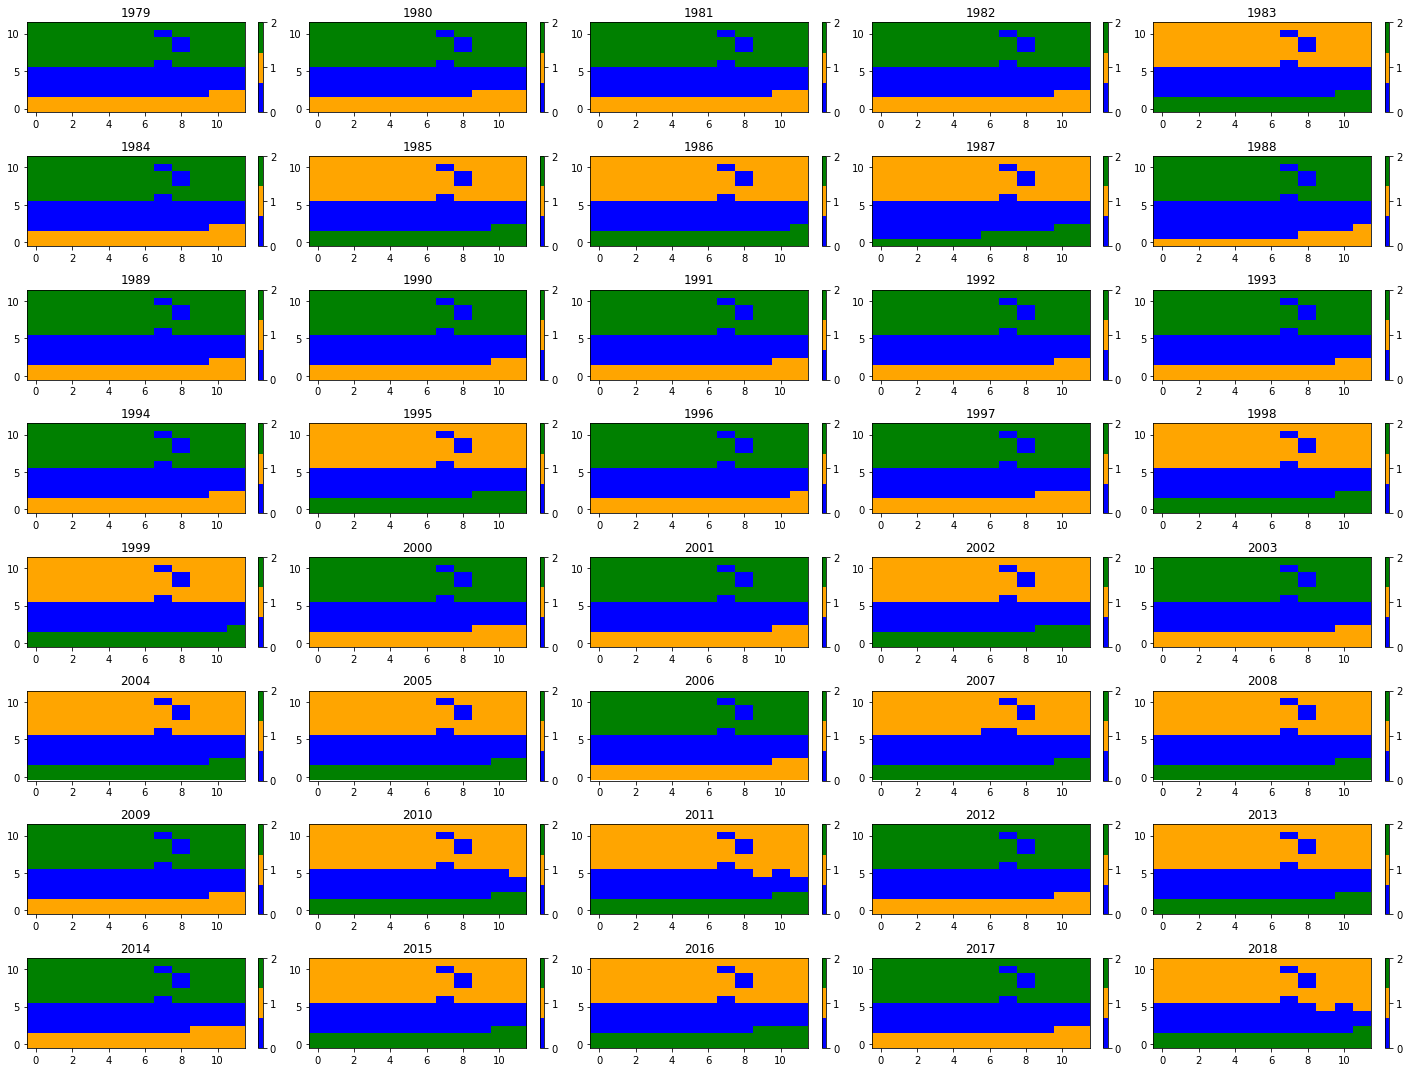

In [18]:
f, axs = plt.subplots(ncols=5, nrows=len(t2m_monthly_mean.groupby('time.year'))//5, figsize=(20,15))

for (year, da), ax in zip(t2m_monthly_mean.groupby('time.year'), axs.flatten()):
    X = da.values.reshape(-1, nlat*nlon)
    ts_kmeans(X, euc_params, title=str(year), ax=ax)
    plt.tight_layout()

### monthly dtw t2m kmeans

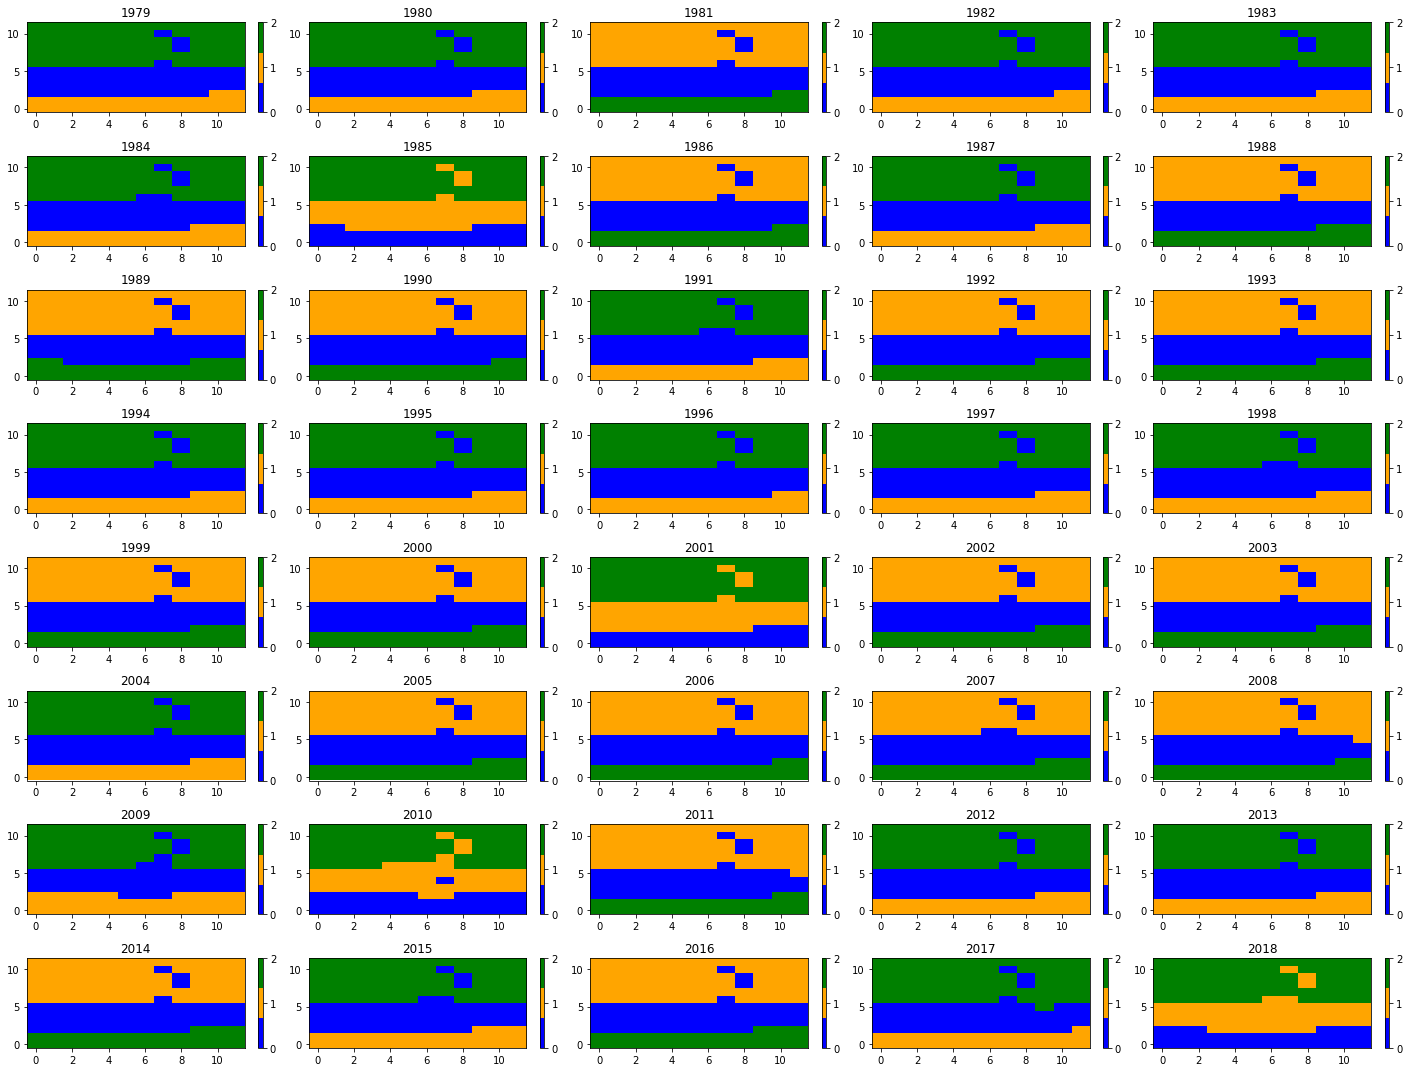

In [22]:
f, axs = plt.subplots(ncols=5, nrows=len(t2m_monthly_mean.groupby('time.year'))//5, figsize=(20,15))

for (year, da), ax in zip(t2m_monthly_mean.groupby('time.year'), axs.flatten()):
    X = da.values.reshape(-1, nlat*nlon)
    ts_kmeans(X, dtw_params, title=str(year), ax=ax)
    plt.tight_layout()

In [ ]:
monthly_mean = ds.t.sel(level=100).resample({'time': '1M'}).mean()

f, axs = plt.subplots(ncols=5, nrows=len(monthly_mean.groupby('time.year'))//5, figsize=(20,15))

for (year, da), ax in zip(monthly_mean.groupby('time.year'), axs.flatten()):
    X = da.values.reshape(-1, nlat*nlon)
    ts_kmeans(X, euc_params, title=str(year), ax=ax)
plt.tight_layout()
plt.show()

### monthly euclidean t kmeans

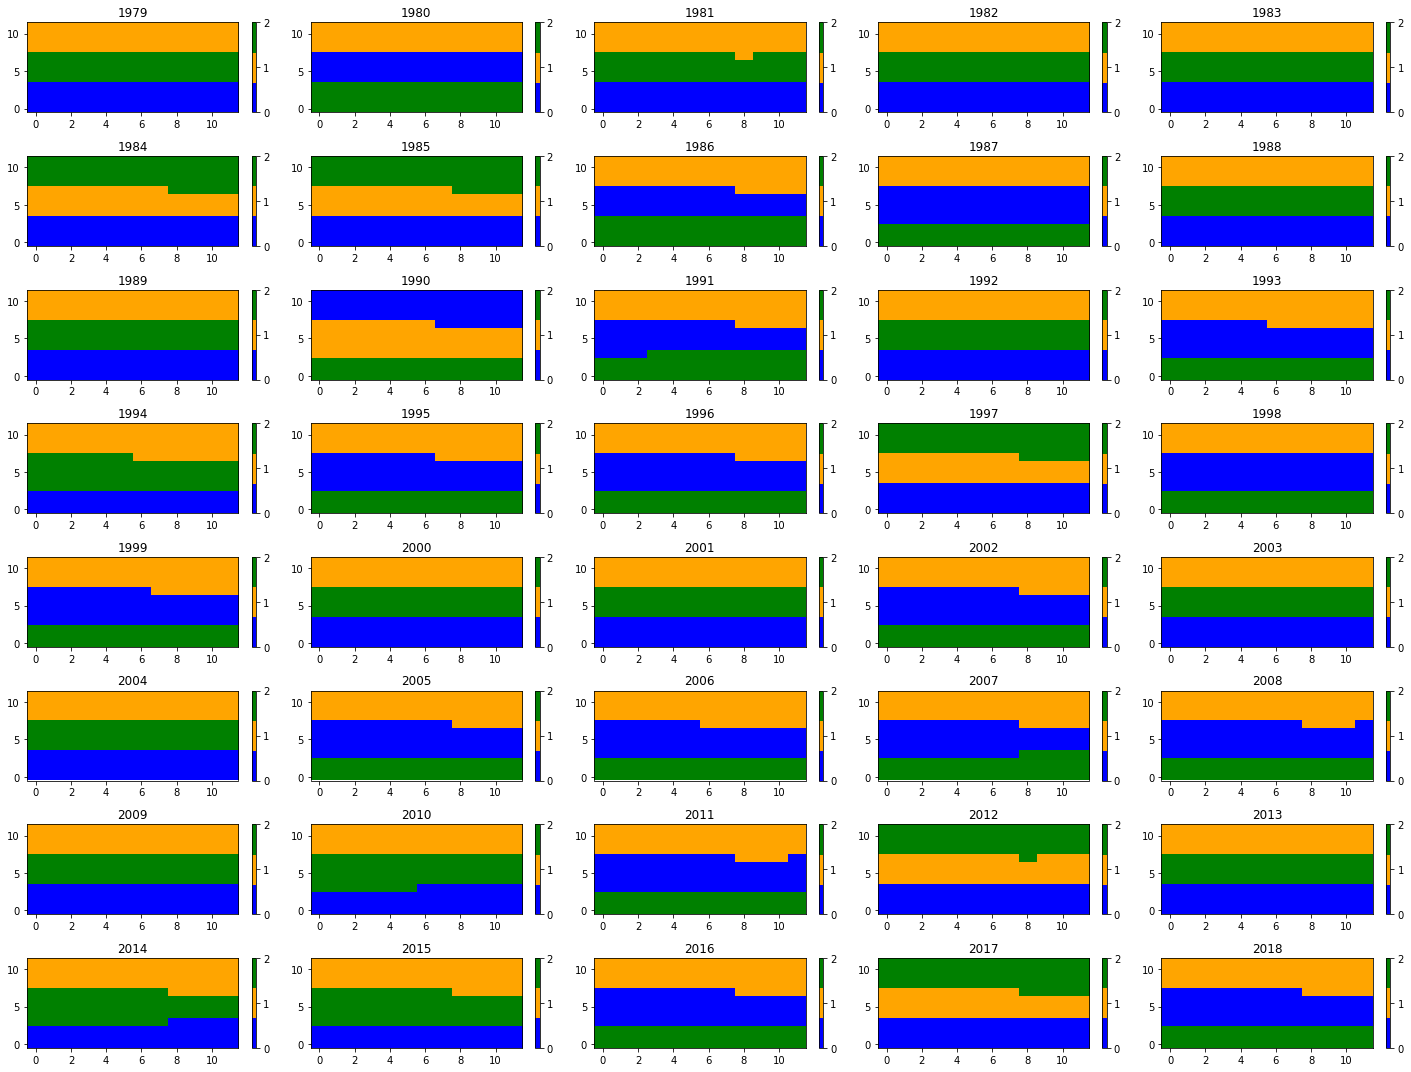

----------------------------------------------------------


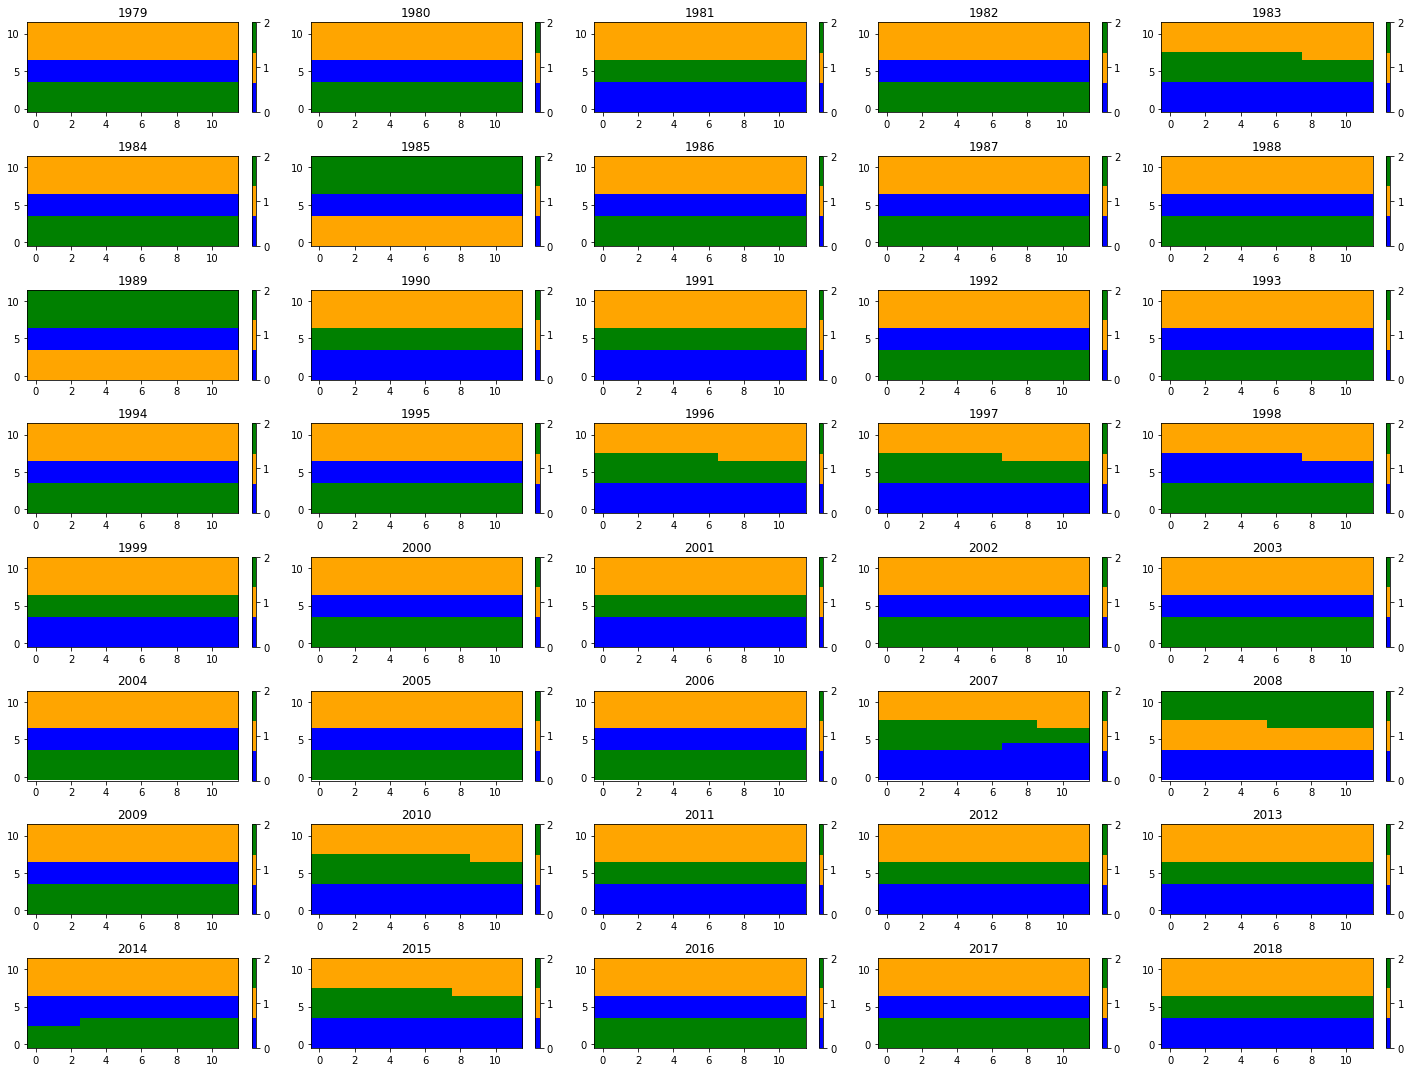

----------------------------------------------------------


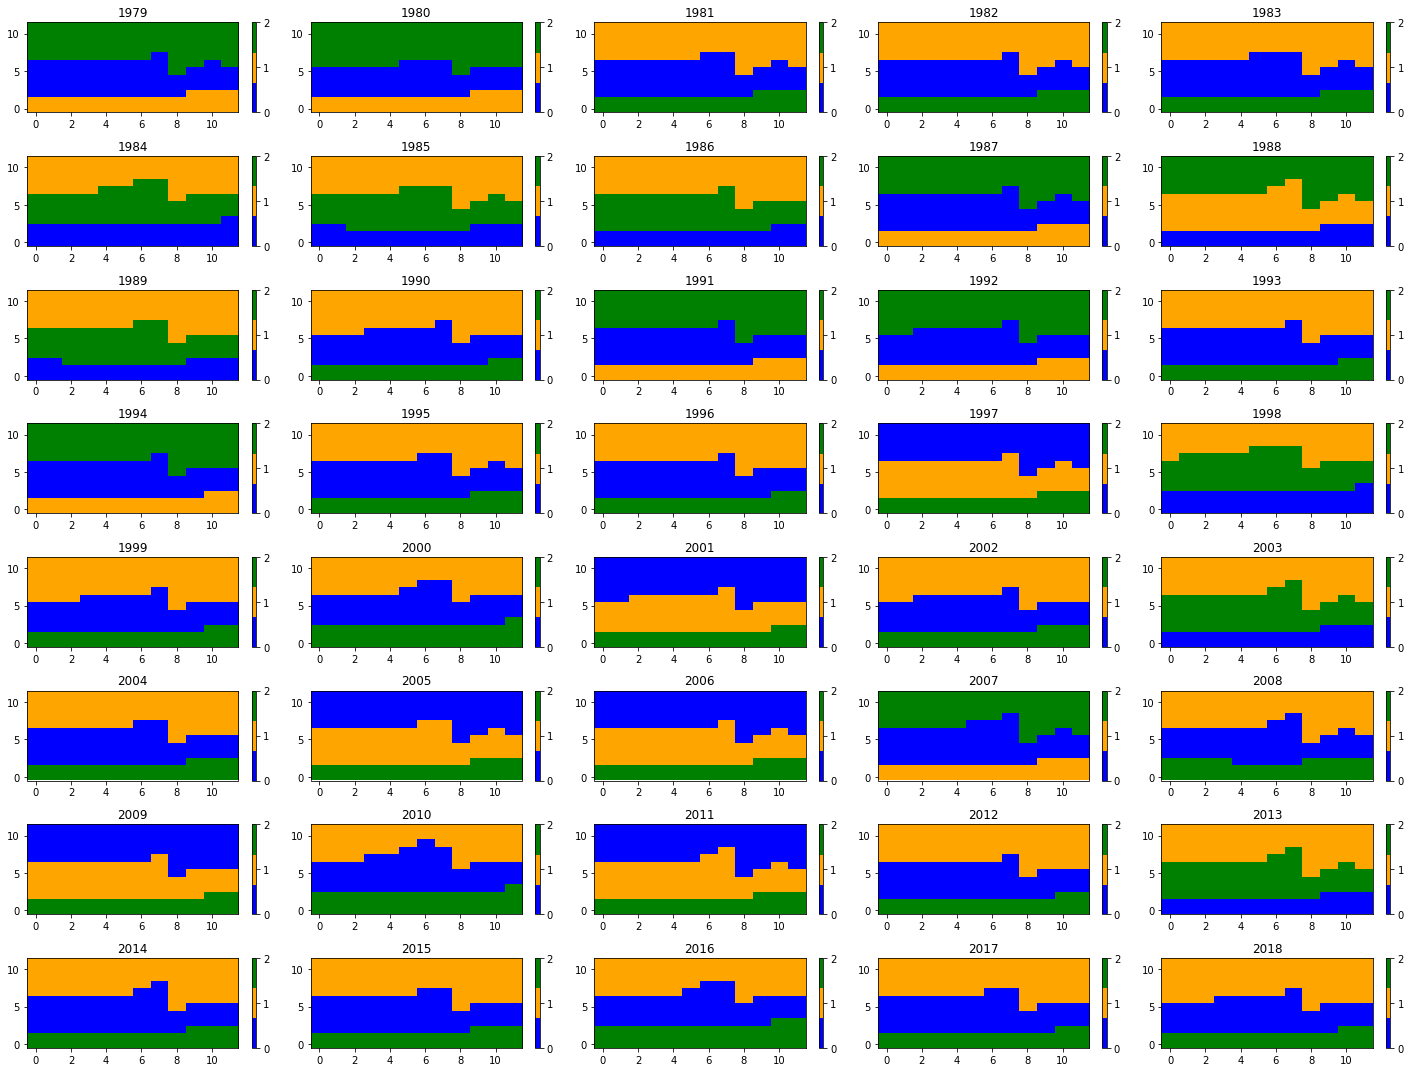

----------------------------------------------------------



In [24]:
levels = [100, 500, 1000]

from tqdm.notebook import tqdm


for level in tqdm(levels):
    monthly_mean = ds.t.sel(level=level).resample({'time': '1M'}).mean()
    
    f, axs = plt.subplots(ncols=5, nrows=len(monthly_mean.groupby('time.year'))//5, figsize=(20,15))
    
    for (year, da), ax in tqdm(zip(monthly_mean.groupby('time.year'), axs.flatten())):
        X = da.values.reshape(-1, nlat*nlon)
        ts_kmeans(X, euc_params, title=str(year), ax=ax)
    plt.tight_layout()
    plt.show()
    print('----------------------------------------------------------')

### monthly dtw t kmeans

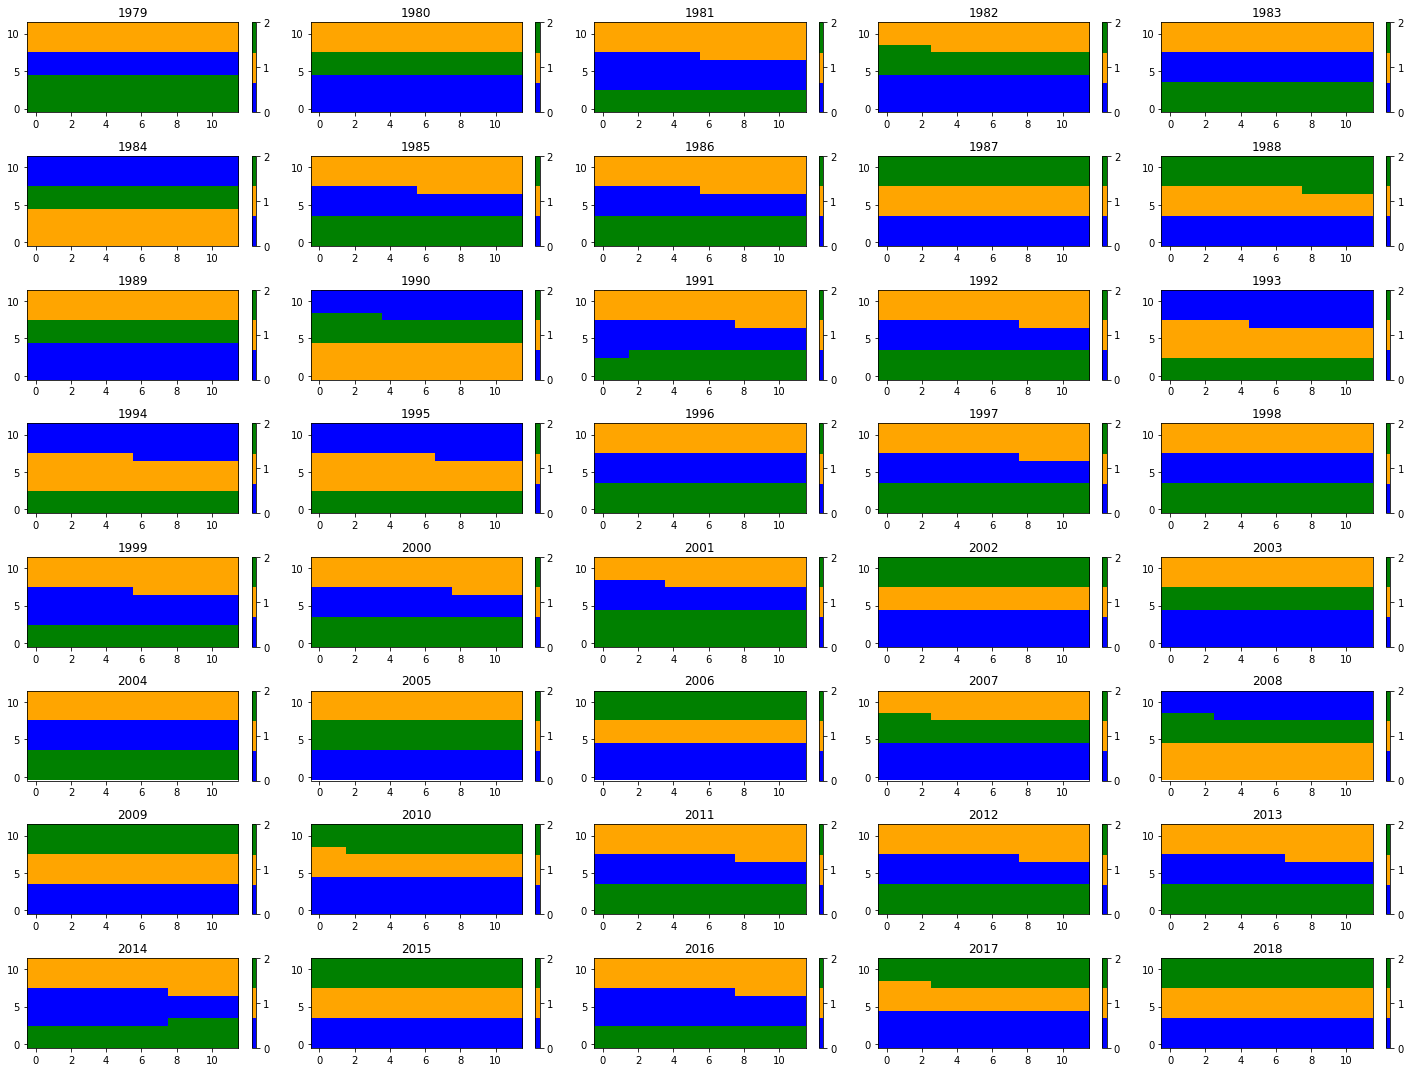

----------------------------------------------------------


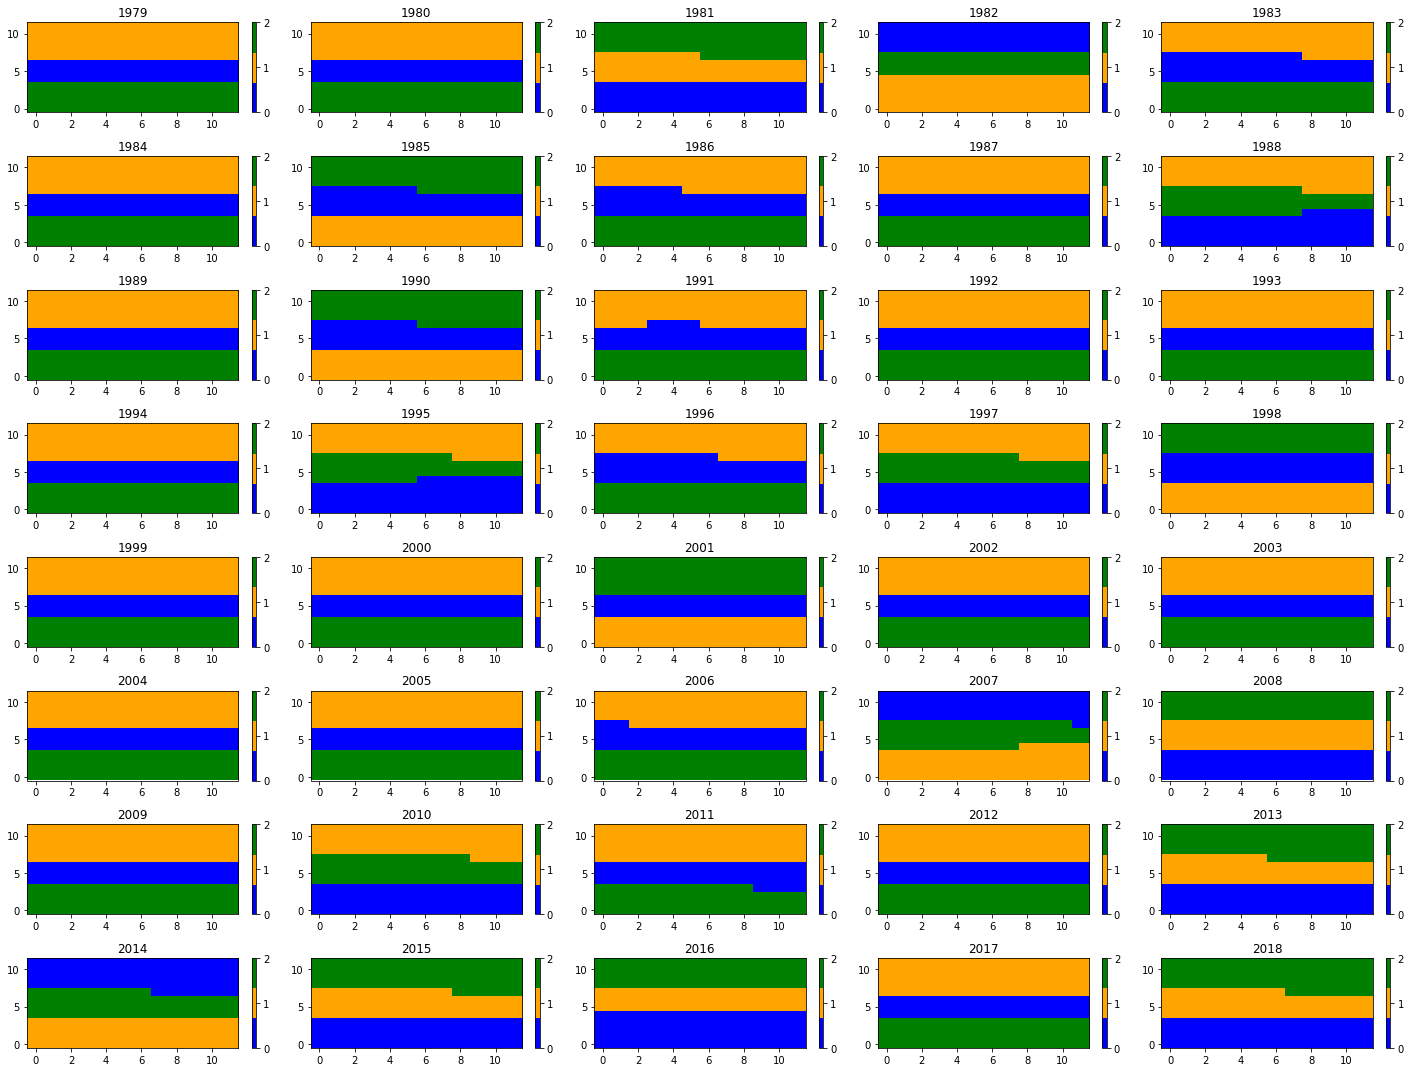

----------------------------------------------------------


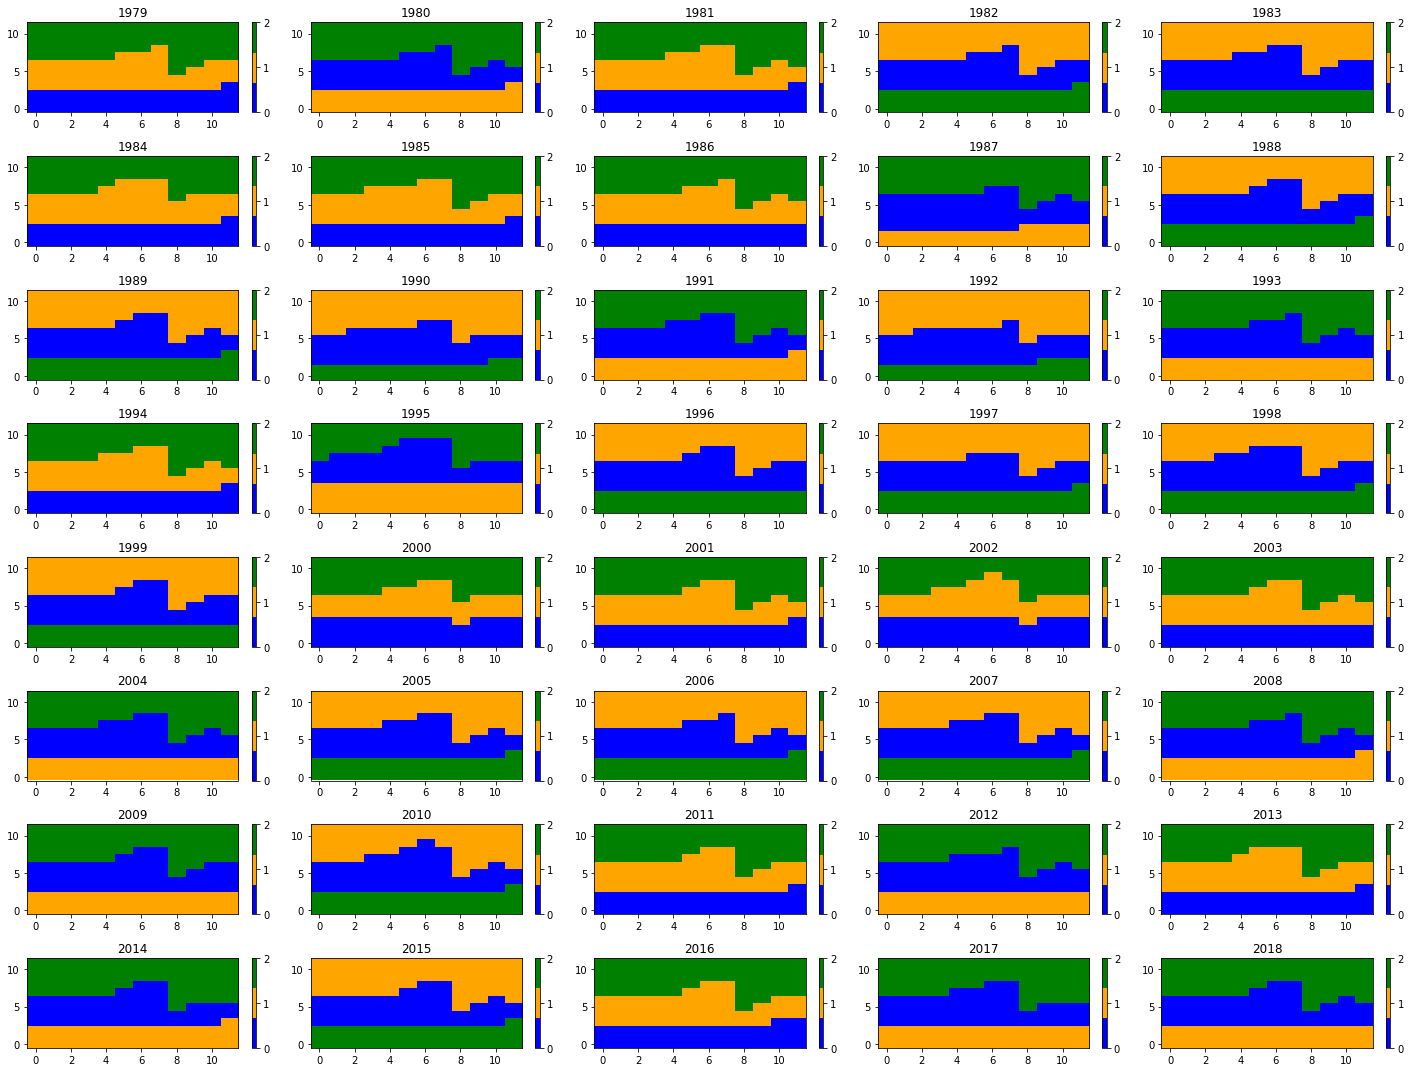

----------------------------------------------------------



In [25]:
levels = [100, 500, 1000]

from tqdm.notebook import tqdm


for level in tqdm(levels):
    monthly_mean = ds.t.sel(level=level).resample({'time': '1M'}).mean()
    
    f, axs = plt.subplots(ncols=5, nrows=len(monthly_mean.groupby('time.year'))//5, figsize=(20,15))
    
    for (year, da), ax in tqdm(zip(monthly_mean.groupby('time.year'), axs.flatten())):
        X = da.values.reshape(-1, nlat*nlon)
        ts_kmeans(X, dtw_params, title=str(year), ax=ax)
    plt.tight_layout()
    plt.show()
    print('----------------------------------------------------------')